In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(0)


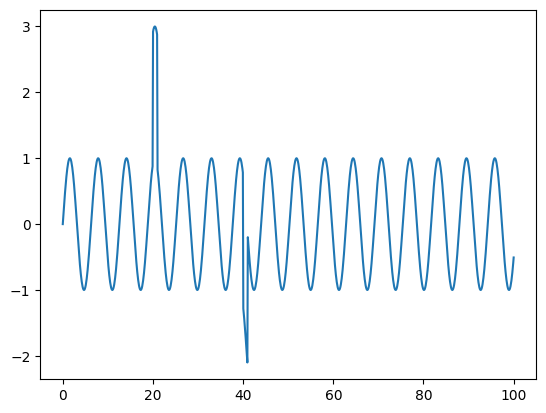

In [2]:
time_steps = np.linspace(0, 100, 1000)
sine_wave = np.sin(time_steps)

anomalies = sine_wave.copy()
anomalies[200:210] += 2
anomalies[400:410] -= 2

plt.plot(time_steps, anomalies)

In [3]:
def create_sequences(data, seq_length): 
    sequences = []
    for i in range(len(data) - seq_length): 
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

window = 20

sine_sequences = create_sequences(sine_wave, window)
anomalies_sequences = create_sequences(anomalies, window)

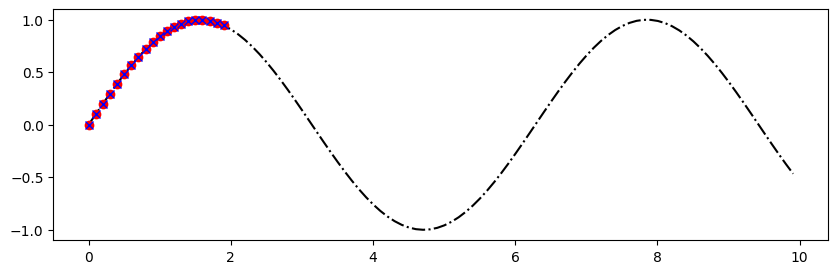

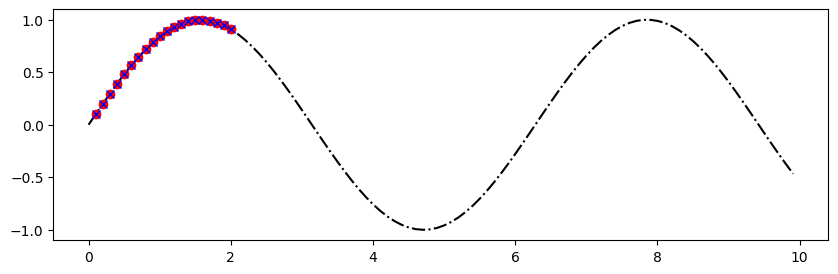

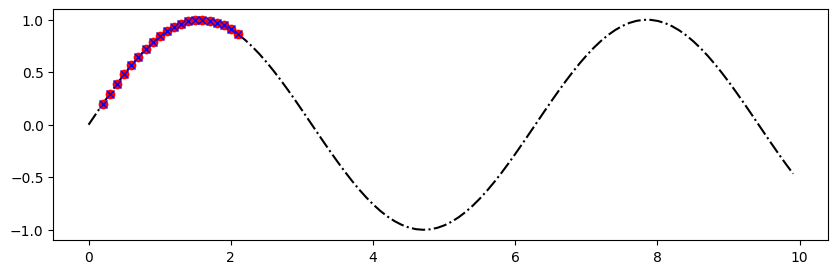

In [4]:
for i in range(3): 
    plt.figure(figsize=(10, 3))
    plt.plot(time_steps[:100], sine_wave[:100], 'k-.')
    plt.plot(time_steps[i:i+window], sine_sequences[i], 'ro')
    plt.plot(time_steps[i:i+window], anomalies_sequences[i], 'bx')


In [5]:
class SequenceDataset(Dataset): 
    def __init__(self, sequences): 
        self.sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

sine_dataset = SequenceDataset(sine_sequences)
anomalies_dataset = SequenceDataset(anomalies_sequences)

In [28]:
sine_dataset[0].shape

AttributeError: 'Subset' object has no attribute 'size'

In [7]:
train_size = int(.8 * len(sine_dataset))
val_size = len(sine_dataset) - train_size
train_dataset, val_dataset = random_split(sine_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(anomalies_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader: 
    print(batch.shape)
    break

torch.Size([64, 20, 1])


In [8]:
class Encoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=1, 
            hidden_size=256, 
            num_layers=1, 
            batch_first=True
        )
        self.lstm2 = nn.LSTM(
            input_size=256, 
            hidden_size=16, 
            num_layers=1, 
            batch_first=True
        )
    
    def forward(self, x):
        x, (hidden, cell) = self.lstm1(x)
        x, (hidden, cell) = self.lstm2(x)
        return x
    
class Decoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=16, 
            hidden_size=256, 
            num_layers=1, 
            batch_first=True
        )
        self.lstm2 = nn.LSTM(
            input_size=256, 
            hidden_size=1, 
            num_layers=1, 
            batch_first=True
        )
        self.fc = nn.Linear(1, 1)
    
    def forward(self, x):
        x, (hidden, cell) = self.lstm1(x)
        x, (hidden, cell) = self.lstm2(x)
        x = self.fc(x)
        return x


class LSTMAutoEncoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
lstm1 = nn.LSTM(
    input_size=1, 
    hidden_size=256, 
    num_layers=1, 
    batch_first=True
)
lstm2 = nn.LSTM(
    input_size=256, 
    hidden_size=16, 
    num_layers=1, 
    batch_first=True
)
lstm3 = nn.LSTM(
    input_size=16, 
    hidden_size=256, 
    num_layers=1, 
    batch_first=True
)
lstm4 = nn.LSTM(
    input_size=256, 
    hidden_size=1, 
    num_layers=1, 
    batch_first=True
)
fc = nn.Linear(1, 1)

x = torch.randn(64, 20, 1)
x1, (hidden1, cell1) = lstm1(x)
x2, (hidden2, cell2) = lstm2(x1)
x3, (hidden3, cell3) = lstm3(x2)
x4, (hidden4, cell4) = lstm4(x3)
x5 = fc(x4)

print(x.shape, x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)


torch.Size([64, 20, 1]) torch.Size([64, 20, 256]) torch.Size([64, 20, 16]) torch.Size([64, 20, 256]) torch.Size([64, 20, 1]) torch.Size([64, 20, 1])


In [10]:
model = LSTMAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def train_model(model, train_loader, val_loader, num_epochs): 
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs): 
        model.train()
        train_loss_sum = 0
        for batch in train_loader: 
            optimizer.zero_grad()
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
        train_loss.append(train_loss_sum / len(train_loader))

        model.eval()
        val_loss_sum = 0
        with torch.no_grad(): 
            for batch in val_loader: 
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch)
                val_loss_sum += loss.item()
        val_loss.append(val_loss_sum / len(val_loader))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}')

    return train_loss, val_loss

train_loss, val_loss = train_model(model, train_loader, val_loader, 100)


Epoch 1/100, Train Loss: 0.4592, Val Loss: 0.3302
Epoch 2/100, Train Loss: 0.2842, Val Loss: 0.2353
Epoch 3/100, Train Loss: 0.2315, Val Loss: 0.2150
Epoch 4/100, Train Loss: 0.2154, Val Loss: 0.2051
Epoch 5/100, Train Loss: 0.2082, Val Loss: 0.1975
Epoch 6/100, Train Loss: 0.1986, Val Loss: 0.1910
Epoch 7/100, Train Loss: 0.1905, Val Loss: 0.1849
Epoch 8/100, Train Loss: 0.1867, Val Loss: 0.1791
Epoch 9/100, Train Loss: 0.1801, Val Loss: 0.1737
Epoch 10/100, Train Loss: 0.1729, Val Loss: 0.1684
Epoch 11/100, Train Loss: 0.1680, Val Loss: 0.1634
Epoch 12/100, Train Loss: 0.1617, Val Loss: 0.1585
Epoch 13/100, Train Loss: 0.1573, Val Loss: 0.1539
Epoch 14/100, Train Loss: 0.1526, Val Loss: 0.1496
Epoch 15/100, Train Loss: 0.1491, Val Loss: 0.1454
Epoch 16/100, Train Loss: 0.1441, Val Loss: 0.1414
Epoch 17/100, Train Loss: 0.1399, Val Loss: 0.1375
Epoch 18/100, Train Loss: 0.1377, Val Loss: 0.1338
Epoch 19/100, Train Loss: 0.1320, Val Loss: 0.1302
Epoch 20/100, Train Loss: 0.1288, Val Lo

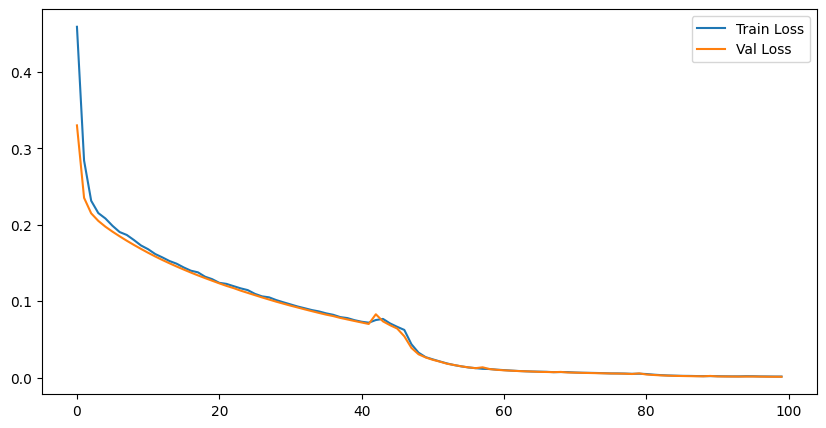

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 980 but corresponding boolean dimension is 1

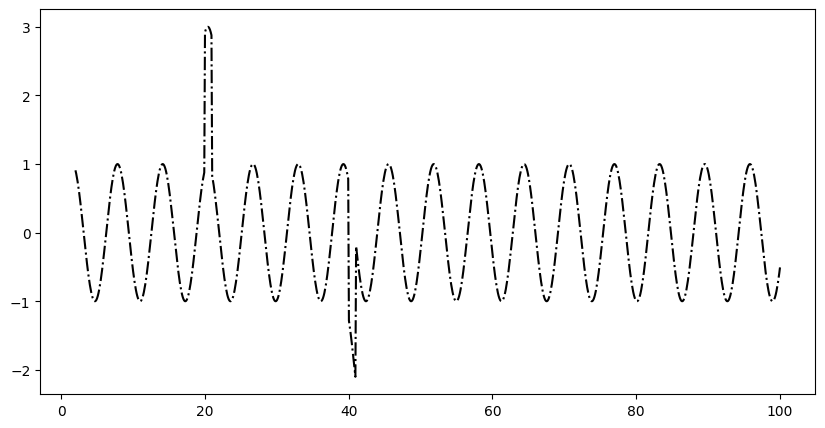

In [31]:
def detect_anomalies(model, dataset, threshold): 
    model.eval()
    losses = []
    # with torch.no_grad(): 
    #     for batch in data_loader: 
    #         inputs = batch.to(device)
    #         outputs = model(inputs)
    #         loss = criterion(outputs, inputs)
    #         losses.append(loss.item())
    with torch.no_grad(): 
        inputs = dataset.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        losses.append(loss.item())
    losses = np.array(losses)
    anomalies = losses > threshold
    return anomalies, losses

threshold = 0.1
indices, losses = detect_anomalies(model, torch.tensor(anomalies_sequences, dtype=torch.float32).unsqueeze(-1), threshold)

plt.figure(figsize=(10, 5))
plt.plot(time_steps[window:], anomalies[window:], 'k-.', label='True Anomalies')
plt.plot(time_steps[window:][indices], anomalies[window:][indices], 'ro', label='Detected Anomalies')
plt.legend()



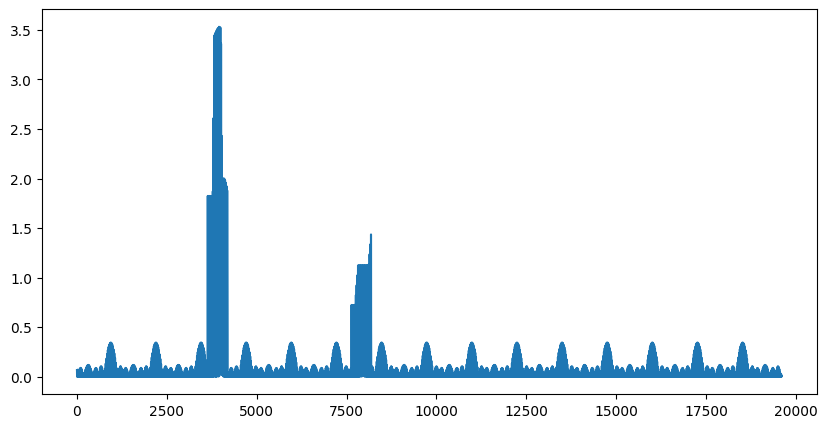

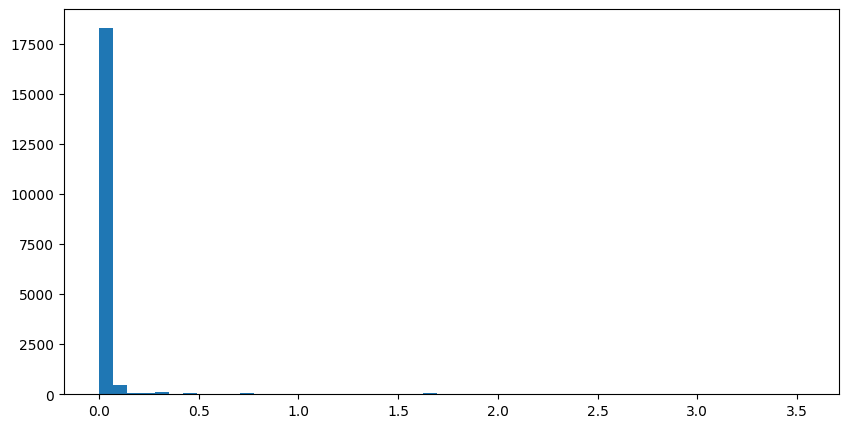

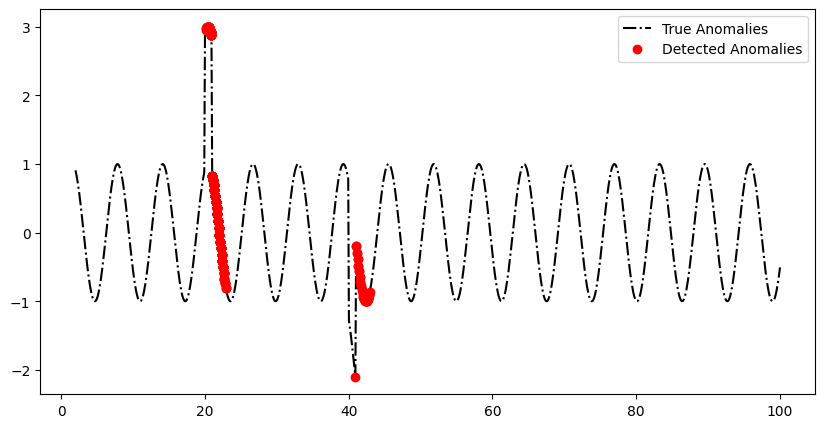

In [51]:
threshold = 1.

model.eval()
with torch.no_grad(): 
    input = torch.tensor(anomalies_sequences, dtype=torch.float32).unsqueeze(-1).to(device)
    output = model(input)
    residual = np.abs(output.cpu().numpy() - input.cpu().numpy())
    indices = np.where(residual > threshold)[0]

plt.figure(figsize=(10, 5))
plt.plot(residual.flatten())
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(residual.flatten(), bins=50)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(time_steps[window:], anomalies[window:], 'k-.', label='True Anomalies')
plt.plot(time_steps[window:][indices], anomalies[window:][indices], 'ro', label='Detected Anomalies')
plt.legend()


(980, 20)

In [122]:
# for input in test_loader: 
#     input = input.to(device)
#     output = model(input).cpu().detach().numpy()
#     break

# anomalies_dataset.sequencesa.shape
# output = model(anomalies_datset.sequences.to(device)).cpu().detach().numpy()

output = model(sine_dataset.sequences.to(device)).cpu().detach().numpy()

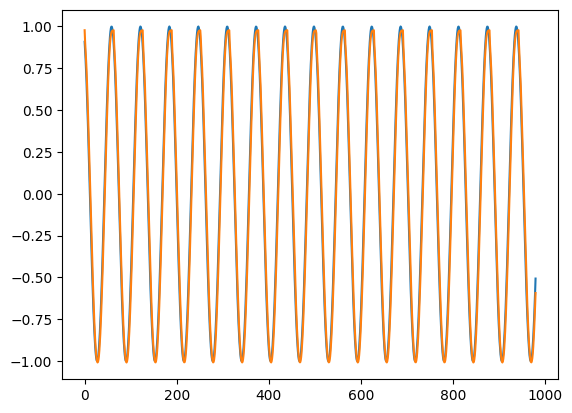

In [123]:
# for i in range(3): 
#     plt.figure(figsize=(10, 3))
#     plt.plot(input[i].cpu().numpy(), 'ro-')
#     plt.plot(output[i], 'bx-')
# plt.plot(anomalies[20:])
plt.plot(sine_wave[20:])
plt.plot(output.squeeze(-1)[:, -1])


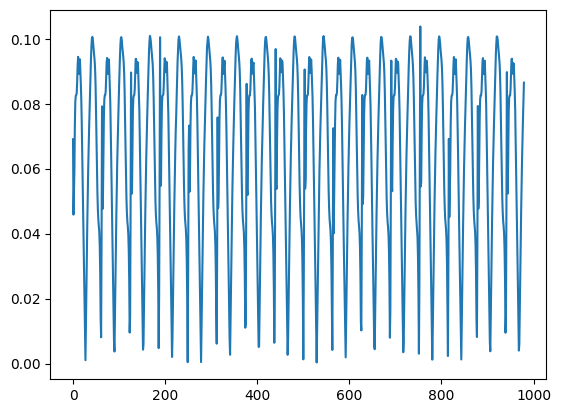

In [124]:
# error = np.abs((anomalies[20:] - output.squeeze(-1)[:, -1]))
error = np.abs((sine_wave[20:] - output.squeeze(-1)[:, -1]))
plt.plot(error)